In [27]:
# Structure
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import random
from wordcloud import WordCloud
# 한글깨짐방지
plt.rc('font', family='Malgun Gothic')

In [2]:
# Load the Data
df = pd.read_csv('df_cluster_05_01_pca_num_5.csv')
df_pca = pd.read_csv('pca_df_cluster_05_01_pca_num_5.csv')
# cluster 열 대치
df['cluster'] = df_pca['cluster']

df = df.iloc[:,1:]
# Load the Data
raw_df = pd.read_csv('data_sample.csv')

# 장르 별 파악을 위해 genre 열 추가
df = pd.merge(df, raw_df[['video_url', 'genre']], on='video_url')
df.columns

Index(['views', 'likes', 'ads_yn', 'duration_seconds', 'subscribers',
       'totalViews', 'ch_avg_views', 'genre_weight', 'date_from_recent',
       'date_from_recent_week', 'cluster', 'video_url', 'title', 'channel_id',
       'genre'],
      dtype='object')

In [3]:
# Shorts 여부 컬럼 추가
df['shorts'] = df['duration_seconds'] < 60
df['shorts'] = df['shorts'].astype('int')
# Cluster 별로 그룹화된 객체 생성
df_grouped = df.groupby('cluster')

(0.0, 10.0)

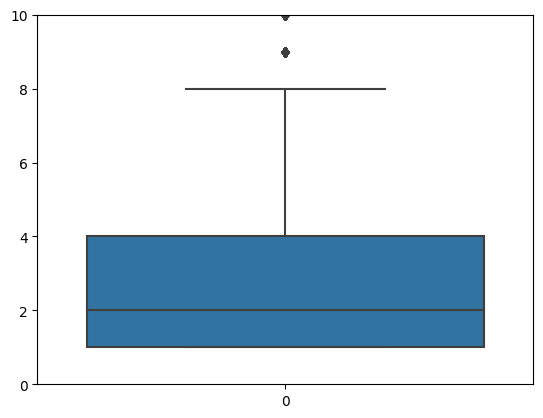

In [4]:
sns.boxplot(df.groupby('channel_id').count()['views'])
plt.ylim(0,10)

# Visualization

## 영상의 개수

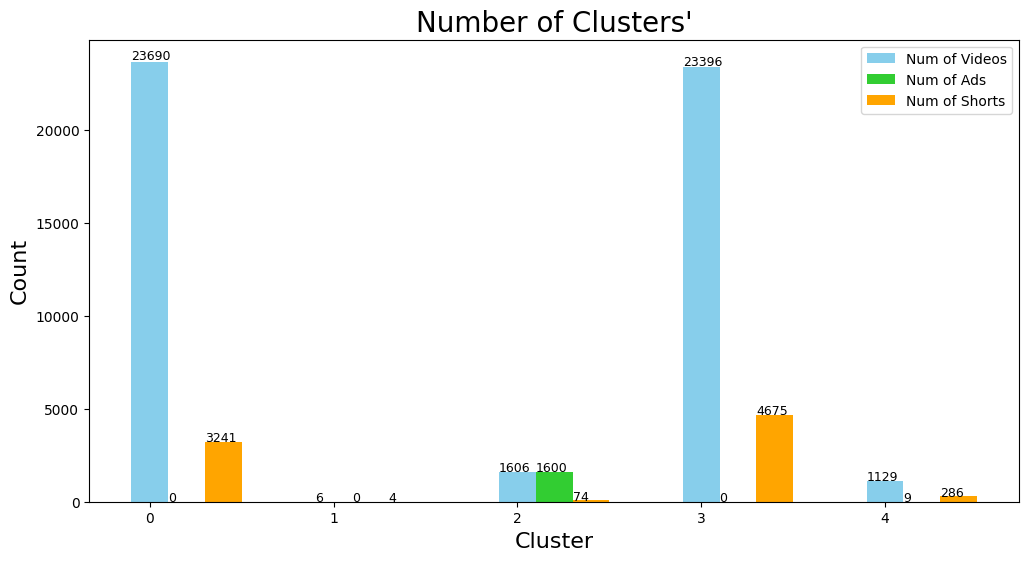

,총 영상 개수,유료광고 영상 개수,숏츠 영상 개수
cluster,,,
0,23690,0,3241
1,6,0,4
2,1606,1600,74
3,23396,0,4675
4,1129,9,286


In [5]:
# 전체 영상, 광고 영상, 숏츠의 개수
video_url_counts = df_grouped['video_url'].count()
ads_yn_counts = df_grouped['ads_yn'].apply(lambda x: x[x == 1].count())
shorts_counts = df_grouped['shorts'].apply(lambda x: x[x == 1].count())

# 막대 그래프를 그립니다.

fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.2

bar1 = ax.bar(video_url_counts.index, video_url_counts, bar_width, color='skyblue', label='Num of Videos')
bar2 = ax.bar(ads_yn_counts.index + bar_width, ads_yn_counts, bar_width, color='limegreen', label='Num of Ads')
bar3 = ax.bar(shorts_counts.index + 2*bar_width, shorts_counts, bar_width, color='orange', label='Num of Shorts')


plt.title("Number of Clusters'", fontsize=20)
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)

# 숫자 추가
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005), fontsize=9)

ax.legend(fontsize=10)
plt.show()
# 데이터프레임으로 표로 만듦
num_df = pd.DataFrame({"총 영상 개수": df_grouped['video_url'].count(),
                      "유료광고 영상 개수": ads_yn_counts,
                      "숏츠 영상 개수": shorts_counts})
num_df

In [6]:
# 1번 클러스터는 예외적으로 다루기 위해
c1_df = df[df['cluster']==1]

In [7]:
# 1번 클러스터만 분리
ex1_df = df[df['cluster']!=1]
# Cluster 1을 제외한 그룹화 객체 생성
df_grouped_ex1 = ex1_df.groupby('cluster')

# Numerical Features


## Median 시각화

In [8]:
# 수치 변수
n_features=['views', 'likes', 'duration_seconds', 'subscribers','totalViews', 'ch_avg_views']
median_df = df_grouped_ex1[n_features].median()
median_df

,views,likes,duration_seconds,subscribers,totalViews,ch_avg_views
cluster,,,,,,
0,2142.5,23.0,435.0,36500.0,1.187340e+07,11710.5
2,11450.0,117.5,671.0,72800.0,2.700391e+07,38878.0
3,1776.0,22.0,320.0,40400.0,1.239485e+07,14052.5
4,38724.0,513.0,208.0,3110000.0,2.147484e+09,358210.0


In [9]:
def barplot_median(median_df, color):
    # Figure와 Subplots 생성
    fig, axs = plt.subplots(2, 3, figsize=(16, 20))
    plt.suptitle('Median of Numeric Features', fontsize=24)
    # numeric value에 대한 boxplot
    for i, feature in enumerate(n_features):
        row = i // 3
        col = i % 3
        sns.barplot(x=median_df.index, y=feature, data=median_df, ax=axs[row, col], palette=color)
        axs[row, col].set_title(f"{feature}", fontsize=20)
        axs[row, col].set_xlabel('Cluster', fontsize=16)
        axs[row, col].set_ylabel(feature, fontsize=16)
    
    # 각 서브플롯 간의 간격 조정
    plt.tight_layout(pad=3)
    
    # 그래프 보여주기
    plt.show()
    
    return

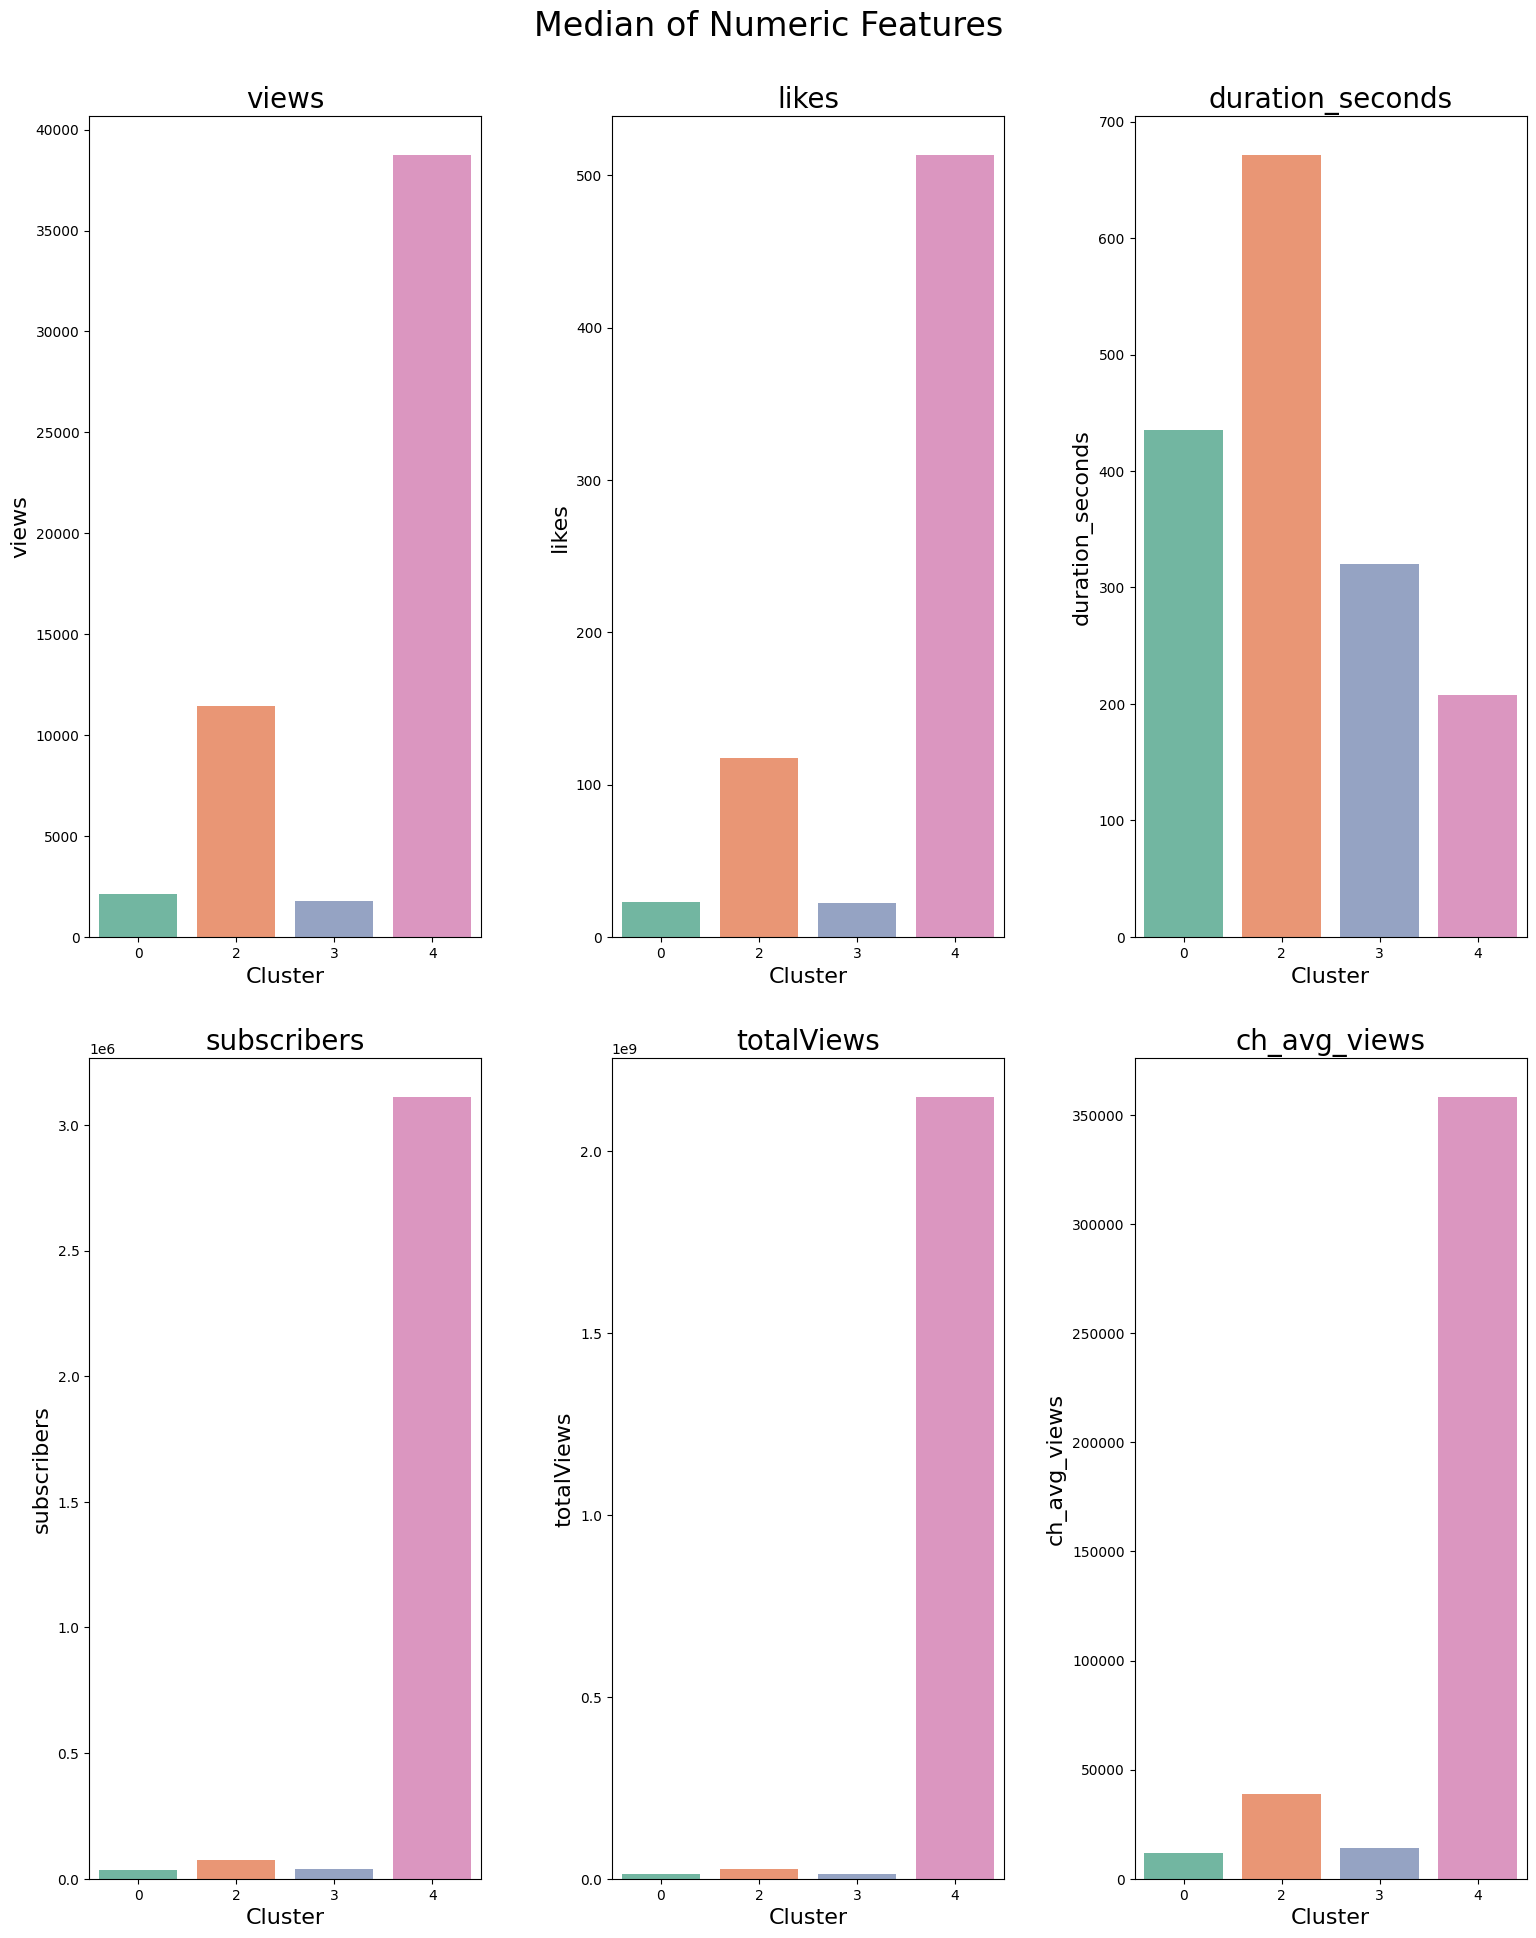

In [10]:
barplot_median(median_df, 'Set2')

## Boxplot

In [11]:
def boxplot_feature(df, color='Set1'):
    # Figure와 Subplots 생성
    fig, axs = plt.subplots(2, 3, figsize=(16, 12))
    plt.suptitle('Boxplots of Numeric Features', fontsize=24)
    # numeric value에 대한 boxplot
    for i, var in enumerate(n_features):
        row = i // 3
        col = i % 3
        sns.boxplot(x='cluster', y=var, data=df, ax=axs[row, col], palette=color)
        axs[row, col].set_title(f"{var}", fontsize=20)
        axs[row, col].set_xlabel('Cluster', fontsize=16)
        axs[row, col].set_ylabel(var, fontsize=16)
        y_max = df[var].quantile(0.95)  # 0.95 quantile used as an example
        axs[row, col].set_ylim(0, y_max)
    
    # 각 서브플롯 간의 간격 조정
    plt.tight_layout(pad=3)
    
    # 그래프 보여주기
    plt.show()
    return

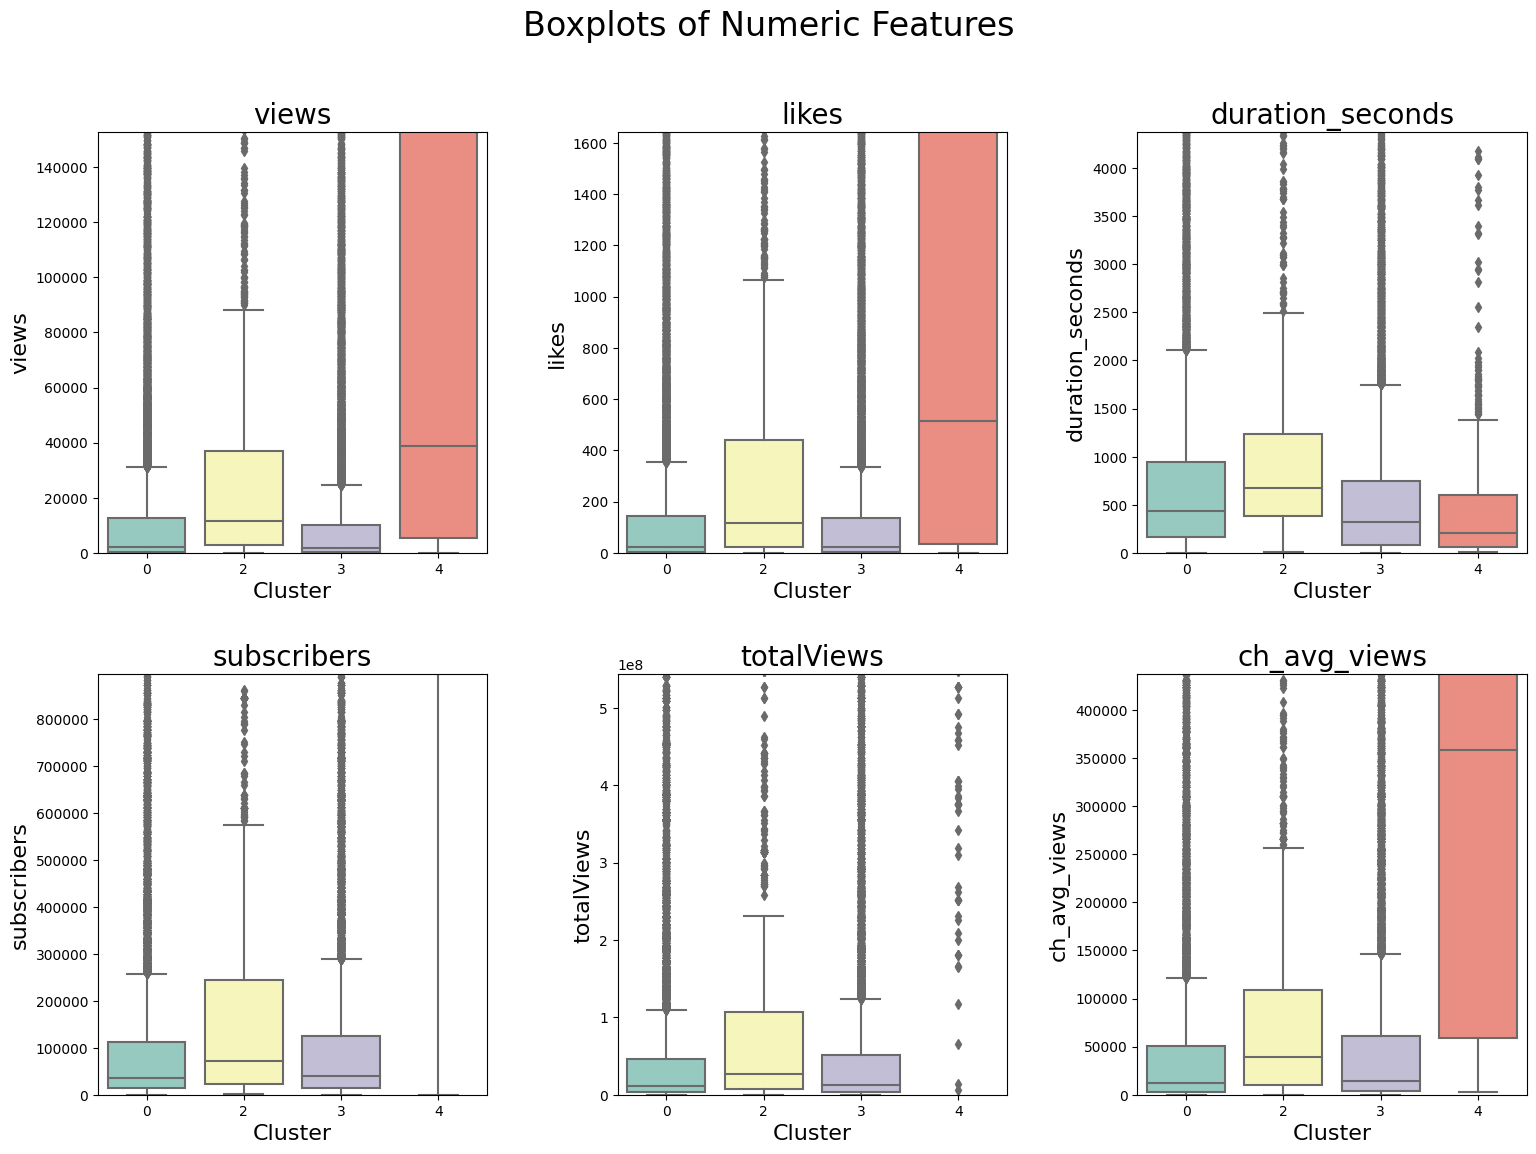

In [12]:
boxplot_feature(ex1_df, color='Set3')

## 이상치 제거
    - Replace outlier with NA

In [13]:
def handle_outlier(ex1_df, lim=1.5):
    # iterate over all unique clusters
    for cluster in ex1_df['cluster'].unique():
        
        ex1_exout_df = ex1_df.copy()
        
        # iterate over all numeric features
        for feature in n_features:
            # 각 피쳐의 Qunitile 값
    
            Q1 = ex1_exout_df[feature].quantile(0.25)
            Q3 = ex1_exout_df[feature].quantile(0.75)
            IQR = Q3 - Q1
    
            # define outliers
            outlier_condition = (ex1_exout_df[feature] < (Q1 - lim * IQR)) | (ex1_exout_df[feature] > (Q3 + lim * IQR))
    
            # replace outliers with NaN
            ex1_exout_df.loc[outlier_condition, feature] = np.nan
            
    return ex1_exout_df

In [14]:
# 이상치 제거한 그룹화 객체
ex1_exout_df = handle_outlier(ex1_df)
grouped_ex1_exout = ex1_exout_df.groupby('cluster')
median_exout_df = grouped_ex1_exout[n_features].median()
median_exout_df

,views,likes,duration_seconds,subscribers,totalViews,ch_avg_views
cluster,,,,,,
0,1288.0,14.0,313.0,30000.0,9326377.0,8701.0
2,5059.0,57.0,577.0,45900.0,16635196.0,23276.0
3,1190.0,13.0,273.0,32200.0,9340572.0,9916.0
4,4733.0,31.5,203.0,36300.0,39661330.0,48189.0


## 이상치를 제거 후 Barplot과 Boxplot 확인

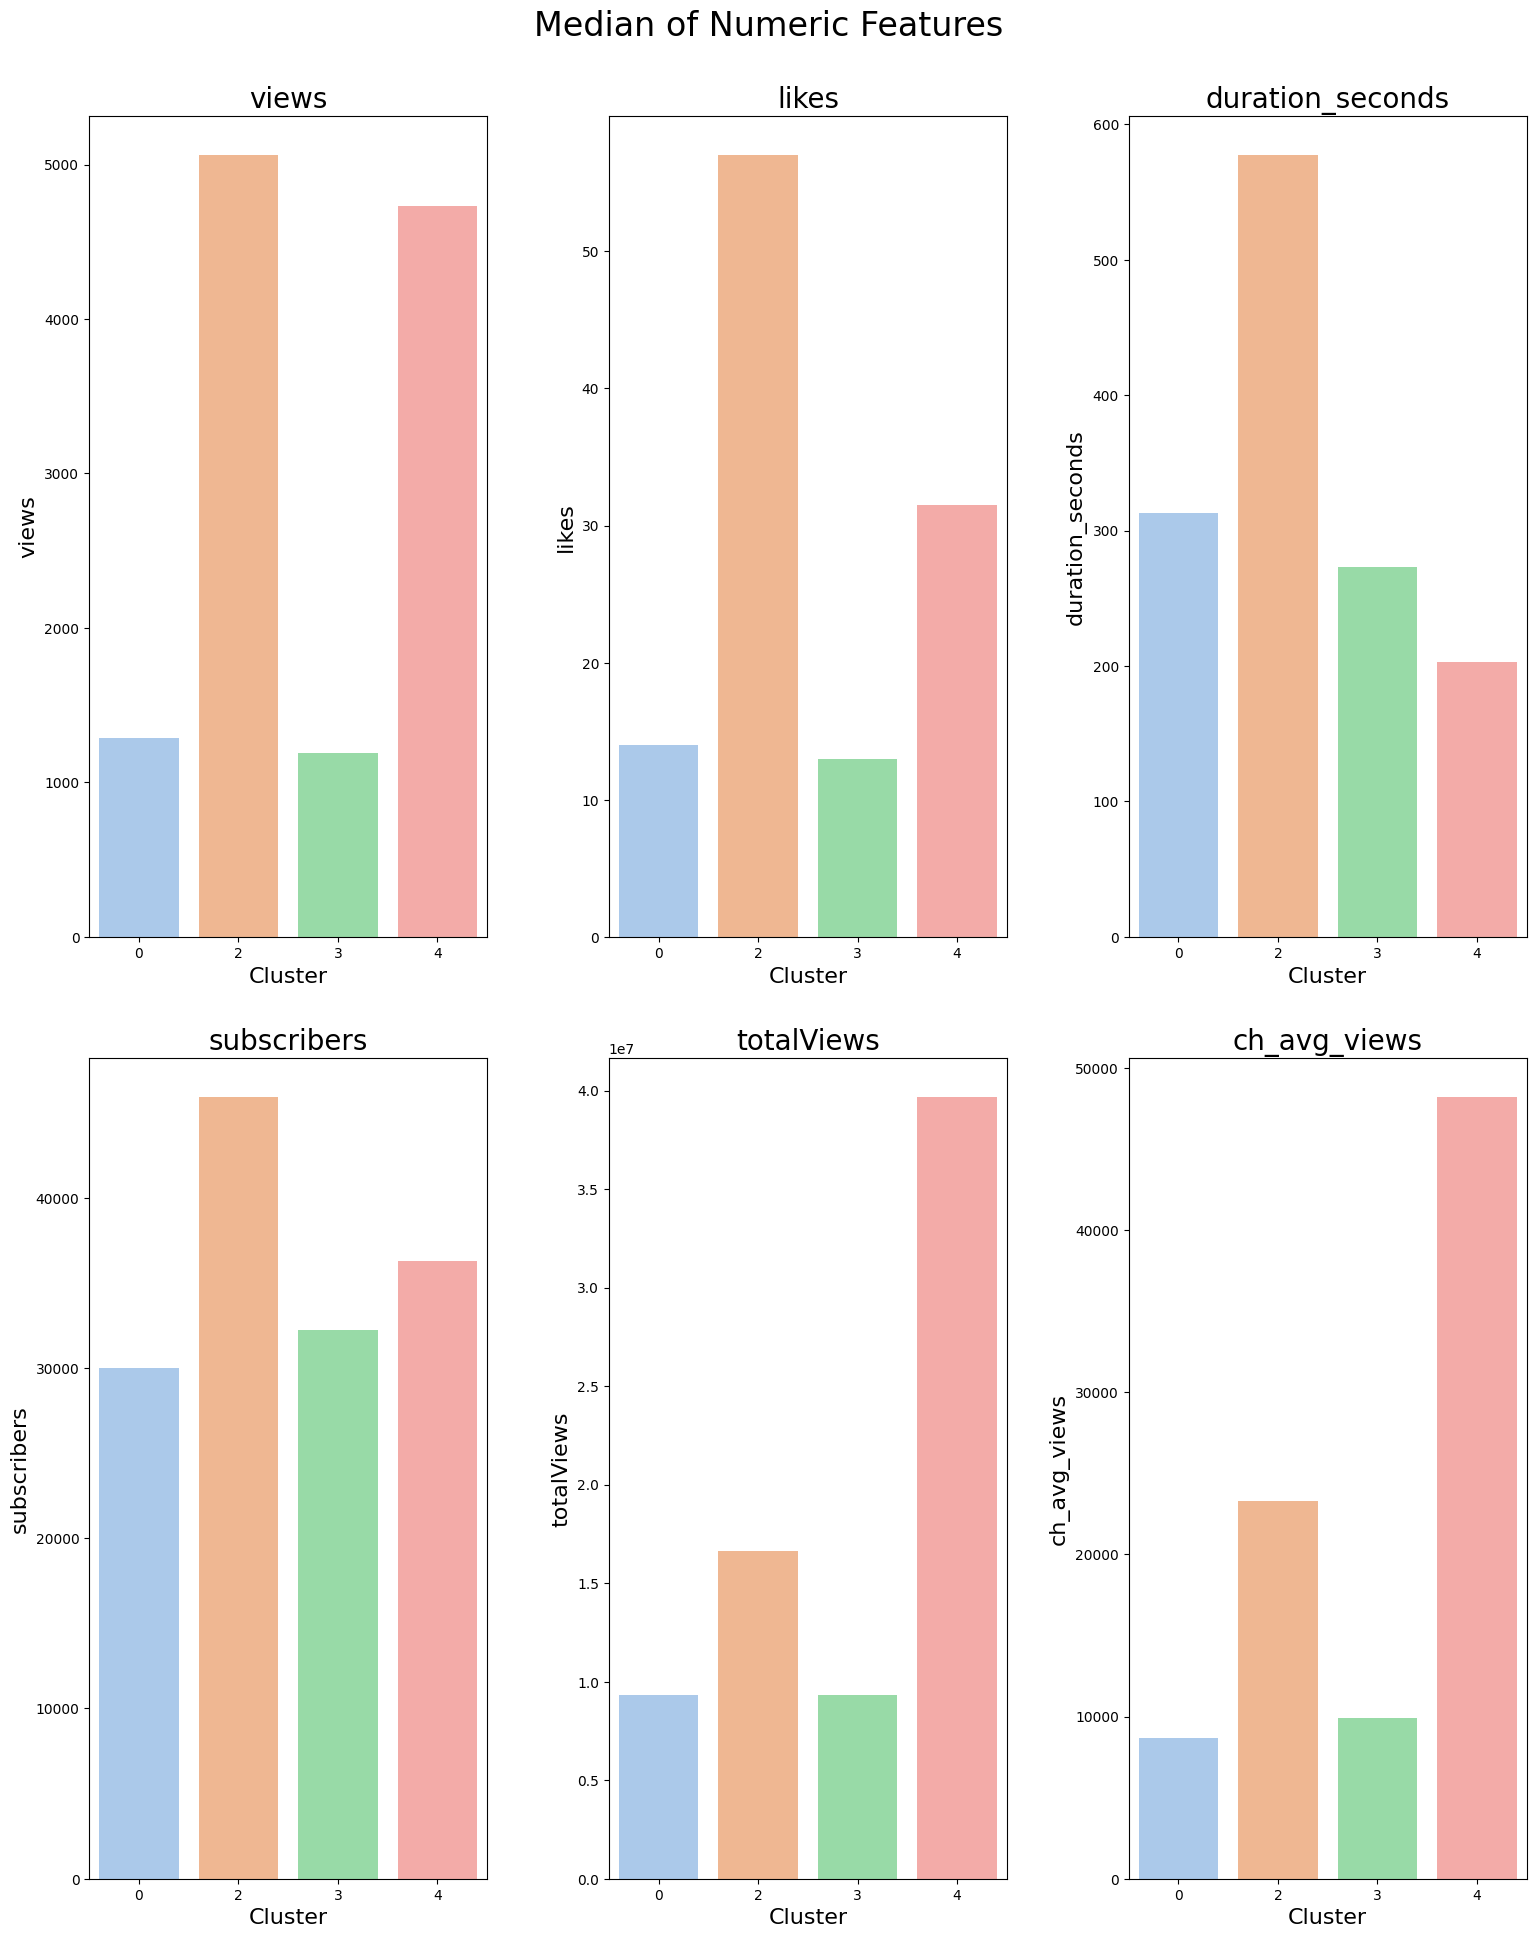

In [15]:
barplot_median(median_exout_df, 'pastel')

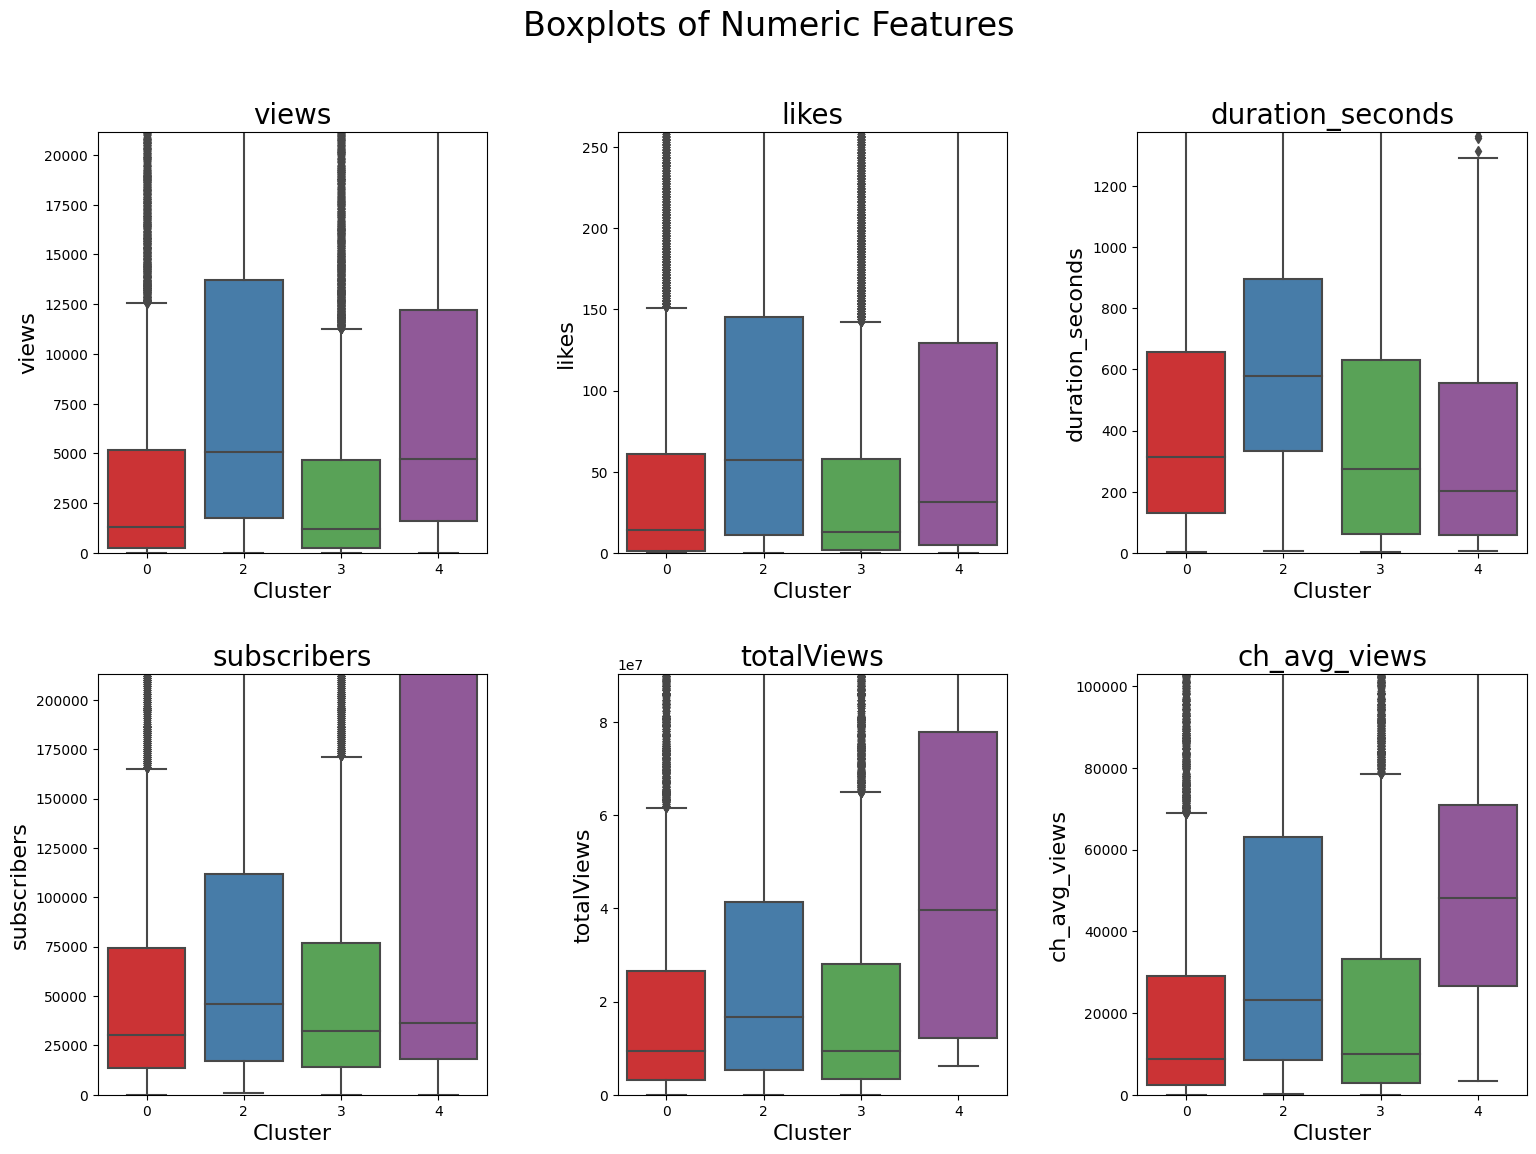

In [16]:
boxplot_feature(ex1_exout_df)

In [17]:
# Figure와 Subplots 생성
# fig, axs = plt.subplots(2, 3, figsize=(15, 12))

# for i, feature in enumerate(n_features):
#     print(feature)
#     row = i // 3
#     col = i % 3
#     sns.histplot(ex1_df[feature], ax=axs[row, col])
#     axs[row, col].set_title(f"Distribution of {feature}", fontsize=20)
#     x_max = ex1_df[feature].quantile(0.9)
#     axs[row, col].set_xlim(0,x_max)

# # 각 서브플롯 간의 간격 조정
# plt.tight_layout(pad=3)

# # 그래프 보여주기
# plt.show()

views


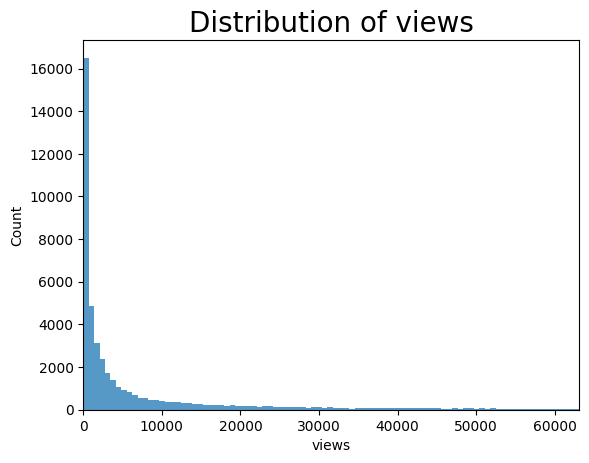

likes


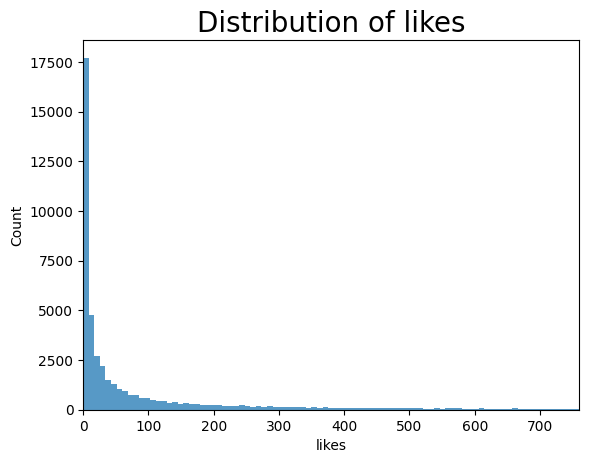

duration_seconds


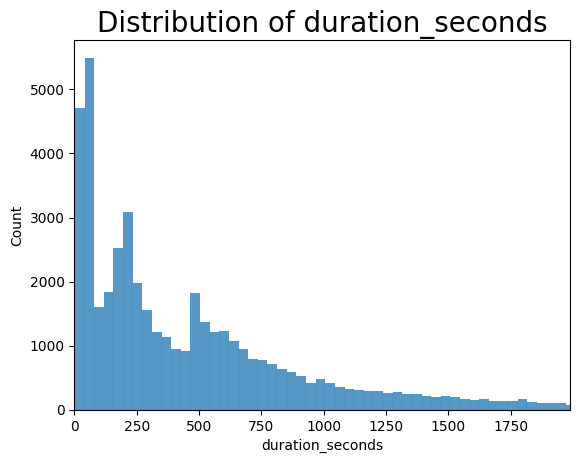

subscribers


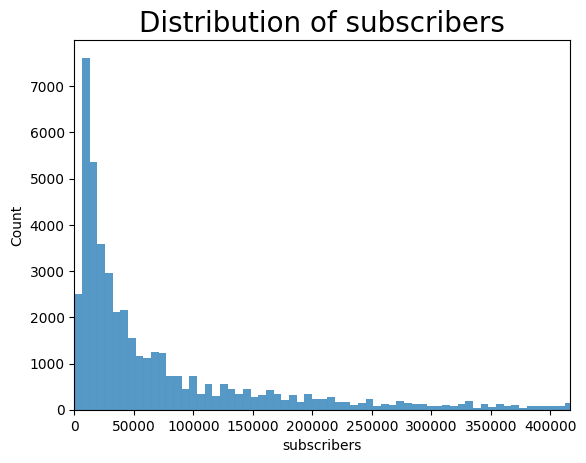

totalViews


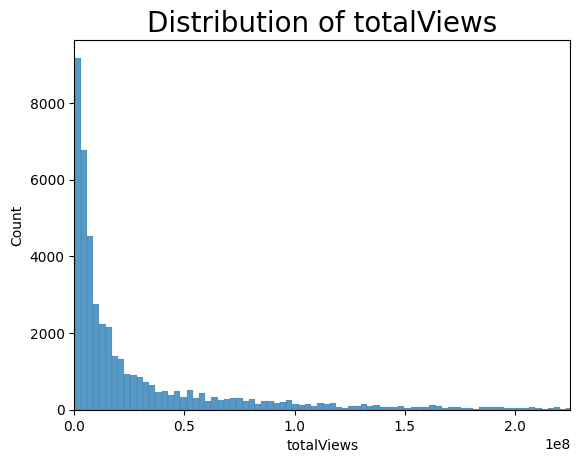

ch_avg_views


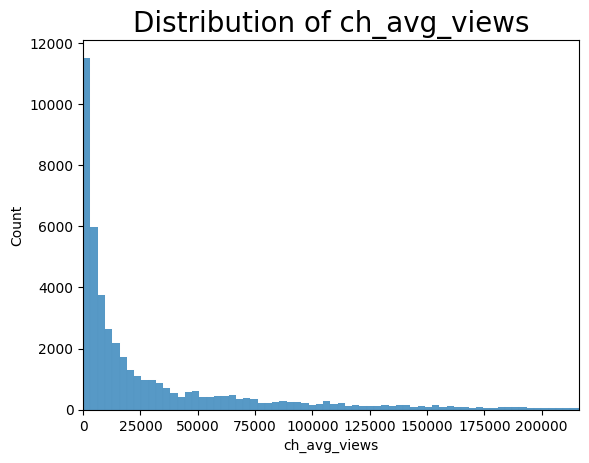

In [18]:
# Figure와 Subplots 생성
for i, feature in enumerate(n_features):
    print(feature)
    sns.histplot(ex1_df[feature])
    plt.title(f"Distribution of {feature}", fontsize=20)
    x_max = ex1_df[feature].quantile(0.9)
    plt.xlim(0,x_max)
    plt.show()

### 채널 별로 EDA
    - TBD

In [19]:
!pip install wordcloud

## 클러스터 별 영상 제목 Word Cloud

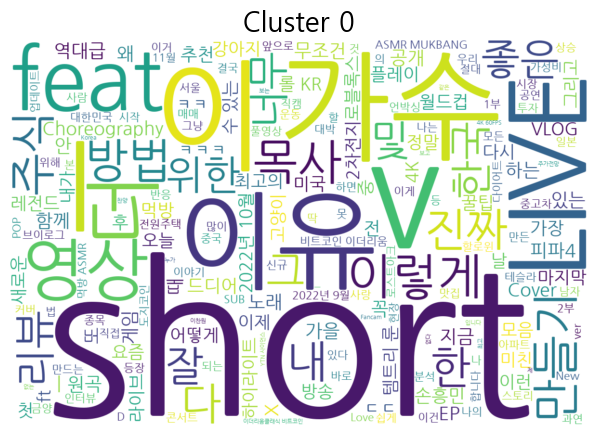

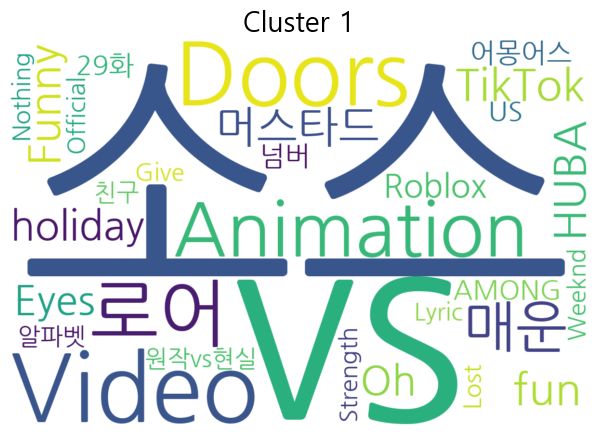

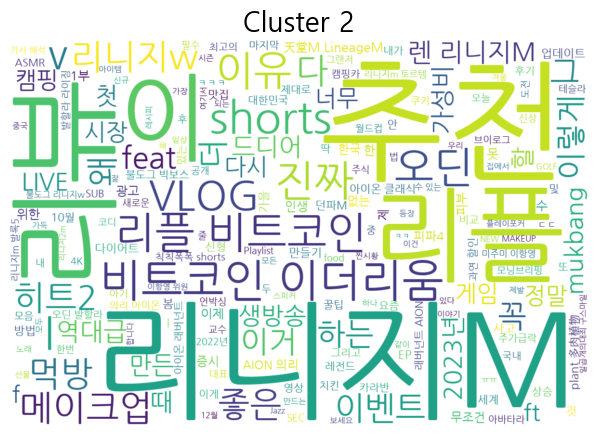

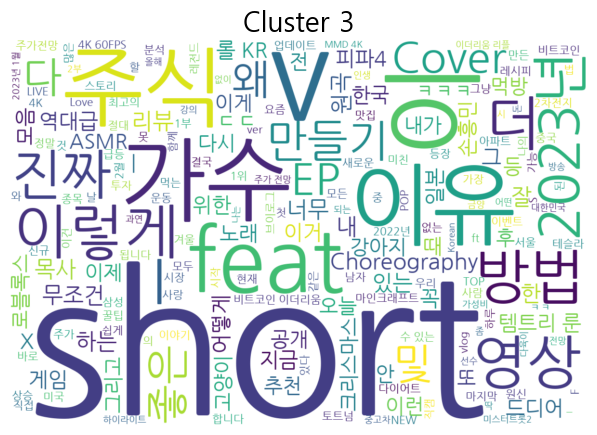

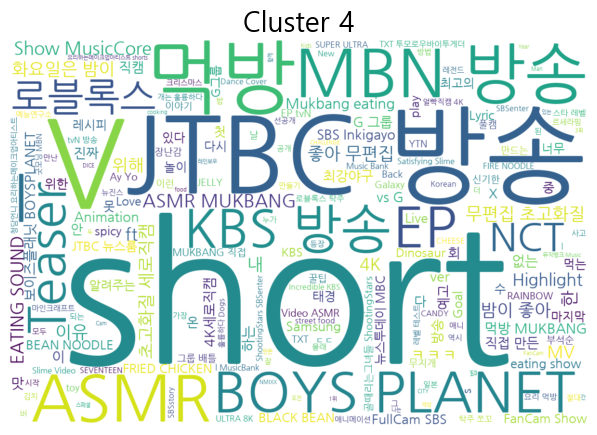

In [31]:

# 클러스터 개수
n_clusters = 5
plt.rc('font', family='Malgun Gothic')
# 클러스터별 워드 클라우드
for i in range(n_clusters):
    # 해당 클러스터의 데이터만 선택
    cluster_data = df[df['cluster'] == i]

    # 'title' 열의 모든 텍스트를 하나의 문자열로 합침
    text = ' '.join(cluster_data['title'])

    # 워드 클라우드 생성
    wordcloud = WordCloud(width=1200, height=800, background_color='white', font_path='NanumGothic').generate(text)

    # 워드 클라우드 그리기
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}', fontsize=20)
    plt.show()


## 광고영상 특징 파악

In [160]:
df[(df['cluster']==4)&(df['ads_yn']==1)]

,views,likes,ads_yn,duration_seconds,subscribers,totalViews,ch_avg_views,genre_weight,date_from_recent,date_from_recent_week,cluster,video_url,title,channel_id,genre,shorts
7992,31672,3849.0,1,66,5020000.0,2.147484e+09,4473924.0,0.16008,102.0,14.0,4,https://www.youtube.com/watch?v=ZrQpEXo3TwY,I-MISSION Ep.시상식 #IMISSION #아이미션 #GIDLE #여자아이들,UCritGVo7pLJLUS8wEu32vow,Music,0
11947,361709,15280.0,1,519,7510000.0,1.511678e+09,497754.0,0.04750,10.0,1.0,4,https://www.youtube.com/watch?v=SfsD1Po6uAM,"Casemiro On Life At United, Old Trafford Atmos...",UC6yW44UGJJBvYTlfC7CRg2Q,Sports,0
14038,20929,0.0,1,554,1940000.0,2.147484e+09,1261000.0,0.08650,100.0,14.0,4,https://www.youtube.com/watch?v=Yzc4tHpt99I,레고® 아바타로 영화 “아바타” 복습하고 “아바타 : 물의 길” 보러 가자!! (f...,UCx8IhwapX8E7uooFYJIeVZw,Entertainment,0
15259,25345,1343.0,1,16,5720000.0,2.147484e+09,1021638.0,0.16008,65.0,9.0,4,https://www.youtube.com/watch?v=bt6WyrVqFMs,[COMING SOON] 아이유 (IU) - 2023 PEPSI X STARSHIP...,UCYDmx2Sfpnaxg488yBpZIGg,Music,1
17147,7662567,26791.0,1,204,3290000.0,1.234231e+09,4622589.0,0.22918,171.0,24.0,4,https://www.youtube.com/watch?v=rnQMwg2OCo8,소맥대전쟁,UCaaZFxjlHI3T_I-uFbldIGA,Gaming,0
22816,57910,3154.0,1,221,7510000.0,1.511678e+09,497754.0,0.04750,111.0,15.0,4,https://www.youtube.com/watch?v=KIc99qt2J7I,"Rashford On Team Spirit, Advice For Youngsters...",UC6yW44UGJJBvYTlfC7CRg2Q,Sports,0
23352,2600688,20474.0,1,753,11000000.0,2.147484e+09,4252443.0,0.08650,110.0,15.0,4,https://www.youtube.com/watch?v=VwEgD87M9qw,리얼먹방:) 굴의 계절이 왔어요~ 굴 무침 & 콜라 삼겹살 수육★ft.쌈채소ㅣSpi...,UCPKNKldggioffXPkSmjs5lQ,Entertainment,0
29405,1154091,9991.0,1,539,1760000.0,1.470427e+09,2683260.0,0.02072,137.0,19.0,4,https://www.youtube.com/watch?v=wc7q3sRavUs,시끄럽게 코고는 돼지놈 뻥튀기 기계로 코뻥뚫어주기 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,UC9ZLv1m7QDLv991X1-p50AA,Comedy,0
37958,21805,1676.0,1,16,5720000.0,2.147484e+09,1021638.0,0.16008,26.0,3.0,4,https://www.youtube.com/watch?v=x0djwqFuw0c,아이유(IU) - 2023 PEPSIxSTARSHIP CAMPAIGN (PEPSI ...,UCYDmx2Sfpnaxg488yBpZIGg,Music,1


In [161]:
df[(df['cluster']==2)&(df['ads_yn']==1)]

,views,likes,ads_yn,duration_seconds,subscribers,totalViews,ch_avg_views,genre_weight,date_from_recent,date_from_recent_week,cluster,video_url,title,channel_id,genre,shorts
30,76740,1494.0,1,1217,845000.0,3.136427e+08,61789.0,0.07442,42.0,6.0,2,https://www.youtube.com/watch?v=egG2mmLrTGA,"BoA 무서운 경고 ""2028년 중국 GDP가 미국을 추월 할 것"" / 금 관리 들...",UCCG6BEYjfQMGzypJw2EJCDQ,Howto & Style,0
87,127761,1715.0,1,232,1670000.0,2.147484e+09,111355.0,0.04292,111.0,15.0,2,https://www.youtube.com/watch?v=3X5YOC8TuHI,17472회. 그렇게 해서 부자 되겠습니까? (휴게소에서 생긴 일),UCH5U89kvHrVxxS80xpoOydw,Autos & Vehicles,0
136,892,0.0,1,61,13700.0,3.497282e+06,3007.0,0.09326,36.0,5.0,2,https://www.youtube.com/watch?v=ZRTh6cKXBJU,라울 꽃대 뽑아주세요. #박시연다육 #국민이다육,UCYRjsm8xHlJveo_RAHzyAbQ,People & Blogs,0
220,31177,0.0,1,524,51100.0,9.097932e+07,23197.0,0.22918,128.0,18.0,2,https://www.youtube.com/watch?v=YudFiXyQ7pQ,[렌] [리니지M] 이 형은 진짜 뭐지... 연금에 진심인데? 풀컬렉 노린다구요? ...,UC1P1pSjj0D_4bX2RteQLyuA,Gaming,0
225,1262,45.0,1,3991,10000.0,1.045676e+06,4166.0,0.08650,161.0,23.0,2,https://www.youtube.com/watch?v=kWl4seW2qDQ,숨어서 몰래 먹던 다이어트 커팅제 공개? [22.09.26 #2],UCJxGt5DQpT8aG-Ist4zWaBg,Entertainment,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49641,2922,32.0,1,386,20900.0,1.420532e+07,8851.0,0.22918,30.0,4.0,2,https://www.youtube.com/watch?v=EOSwsBNcIb4,[히트2] 골드로 다이아버는 절대 추천하지 않는방법,UC4tQqXb9fG8_xexCbTp2bjQ,Gaming,0
49664,75283,957.0,1,796,483000.0,5.808429e+08,45492.0,0.22918,136.0,19.0,2,https://www.youtube.com/watch?v=6DDcgWWTqIU,오랜만에 조카랑 놀아주는 삼촌들,UCyHvSKT_bLDYpkv1JjjsLAg,Gaming,0
49686,981513,6687.0,1,1114,2140000.0,1.977798e+08,1354656.0,0.07442,116.0,16.0,2,https://www.youtube.com/watch?v=rGoDNiEQd5A,일주일 동안 먹은 맛있는 집밥 7가지 / 맛있는 집밥을 위한 살림템 추천,UCg_xrQ9KMN7wL4moBwuxZWw,Howto & Style,0
49782,1819,46.0,1,536,8630.0,1.948322e+06,3178.0,0.22918,173.0,24.0,2,https://www.youtube.com/watch?v=sy_GtUr50nw,"[리니지M] ""어이~ 강프로 층줌은 잡쉈고??"" 오만의탑 층줌 멸망전 [대박TV] ...",UCdX0dzh32J2CU52AlB-ABmg,Gaming,0
